## [詳解ディープラーニング　TensorFlow・Kerasによる時系列データ処理](https://book.mynavi.jp/ec/products/detail/id=72995)
　巣籠悠輔 著  
　マイナビ出版  
　ISBN : 978-4-8399-6251-7  
　発売 : 2017/05/30  
  
support site : [https://book.mynavi.jp/supportsite/detail/9784839962517.html](https://book.mynavi.jp/supportsite/detail/9784839962517.html)  
github : [yusugomori/deeplearning-tensorflow-keras](https://github.com/yusugomori/deeplearning-tensorflow-keras) 

Most of codes and explanations in this notebook are based on the textbook.  
If you want to use codes in this notebook, please check the book and original codes from the above.  

---
## ３章　単純パーセプトロン　続き

---
### 多クラスロジスティック回帰

#### ソフトマックス関数
多クラス分類については、シグモイド関数の代わりにソフトマックス関数

\begin{align*}
\text{softmax}(x)_{i} &= \frac{\mathrm{e}^{x_{i}}}{\sum^{n}_{j=1}\mathrm{e}^{x_{i}}} & (i = 1, 2, \dots, n)
\end{align*}

が用いられる。  
ソフトマックス関数は、$n=2$ のとき

\begin{align*}
\text{softmax}(x)_{1} = \frac{\mathrm{e}^{x_{1}}}{\mathrm{e}^{x_{1}} + \mathrm{e}^{x_{2}}} = \frac{1}{1 + \mathrm{e}^{x_{2}-x_{1}}}
\end{align*}

と変形できる。  
  
また、$y_{i} = \text{softmax}(x)_{i}$ とおくとき、  

\begin{align*}
0 < y_{i} < 1 \\
\sum_{i=1}^{n}y_{i} = 1
\end{align*}

が成り立つ。

さて、

\begin{align*}
Z := \sum_{j=1}^{n}\mathrm{e}^{x_{i}}
\end{align*}

とおくとき、ソフトマックス関数の微分は

\begin{align*}
\text{when} \, &(i=j) & \frac{\partial y_{i}}{\partial x_{i}} &= \frac{\mathrm{e}^{x_{i}}Z - \mathrm{e}^{x_{i}}\mathrm{e}^{x_{i}}}{Z^{2}} = y_{i}(1-y_{i}) \\
&(i \neq j) & \frac{\partial y_{i}}{\partial x_{i}} &= \frac{- \mathrm{e}^{x_{i}}\mathrm{e}^{x_{j}}}{Z^{2}} = - y_{i}y_{j}
\end{align*}

となるので、これをまとめて

\begin{align*}
\frac{\partial y_{i}}{\partial x_{i}} =\begin{cases}
y_{i}(1-y_{i}) & (i=j) \\
- y_{i}y_{j} & (i \neq j)
\end{cases}\end{align*}

と表すことができる。

---
#### 多クラス分類のモデル化

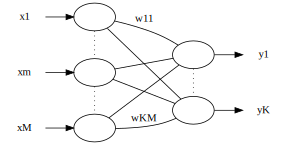

In [1]:
from graphviz import Digraph

dot = Digraph()
dot.graph_attr['rankdir']='LR'
dot.graph_attr['size']="4,4"

with dot.subgraph(name='b_0_0') as c00:
    c00.node('x1', 'x1', shape='plaintext')
    c00.node('l11', '')
    c00.edge('x1', 'l11')
    c00.attr(label='abcde')
with dot.subgraph(name='b_0_1') as c01:
    c01.node('xm', 'xm', shape='plaintext')
    c01.node('l1m', '')
    c01.edge('xm', 'l1m')
with dot.subgraph(name='b_0_2') as c02:
    c02.node('xM', 'xM', shape='plaintext')
    c02.node('l1M', '')
    c02.edge('xM', 'l1M')
with dot.subgraph(name='b_1_0') as c10:
    c10.node('l21', '')
    c10.node('y1', 'y1', shape='plaintext')
    c10.edge('l21', 'y1')
with dot.subgraph(name='b_1_0') as c11:
    c11.node('l2K', '')
    c11.node('yK', 'yK', shape='plaintext')
    c11.edge('l2K', 'yK')
    
dot.edge('l11', 'l21', arrowhead='none', label='w11')
dot.edge('l1m', 'l21', arrowhead='none')
dot.edge('l1M', 'l21', arrowhead='none')
dot.edge('l11', 'l2K', arrowhead='none')
dot.edge('l1m', 'l2K', arrowhead='none')
dot.edge('l1M', 'l2K', arrowhead='none', label='wKM')
    
dot.edge('l11', 'l1m', style='dotted', arrowhead='none')
dot.edge('l1m', 'l1M', style='dotted', arrowhead='none')
dot.edge('l21', 'l2K', style='dotted', arrowhead='none')
dot.body.append('{rank=min; x1; xm; xM;}')
dot.body.append('{rank=same; l11; l1m; l1M;}')
dot.body.append('{rank=same; l21; l2K;}')
dot.body.append('{rank=max; y1; yK;}')
    
dot

多クラス分類のため、上図のように入出力を拡張した１層パーセプトロンを考える。  
入力がM次元ベクトル $X=(x_{1}, x_{2}, \dots, x_{M})^{\mathrm{T}}$ 、出力がK次元ベクトル $Y=(y_{1}, y_{2}, \dots, y_{K})^{\mathrm{T}}$ であるとき、  
あるノードkからのニューロンの出力 $y_{k}$ は

\begin{align*}
y_{k} &= f(W_{k,1}x_{1} + W_{k,2}x_{2} + \dots + W_{k,M}x_{M} + b_{k}) \\
&= f(W^{T}_{k}X + b_{k})
\end{align*}

となる。すると、

\begin{align*}
W &= (W_{1} + W_{2} + \dots + W_{k} + \dots + W_{K})^{\mathrm{T}} \\
& \\
&=\left(
    \begin{array}{ccccc}
      w_{11} & \dots & w_{1n} & \dots & w_{1M} \\
      \vdots & & \vdots & & \vdots \\
      w_{k1} & \dots & w_{kn} & \dots & w_{kM} \\
      \vdots & & \vdots & & \vdots \\
      w_{K1} & \dots & w_{Kn} & \dots & w_{KM} \\
    \end{array}
  \right) \\
& \\
b &= \left( \begin{array}{ccc} b_{1} \\ \vdots \\ b_{k} \\ \vdots \\ b_{K} \end{array} \right)
\end{align*}

に対して、モデルの出力全体は

\begin{align*}
Y = f(WX + b)
\end{align*}

と表せる。  
ここで、 $W$ を重み行列、 $b$ をバイアスベクトルと呼ぶ。  
  
活性化関数 $f$ をソフトマックス関数とすることで多クラス分類課題に使えるようになるため、  
このモデルを多クラスロジスティック回帰という。  

いま、入力 $X$ に対して、分類されるいずれかのクラス値を取る確率変数を $C$ とする。  
クラス数がKであるとき、$C$ は1からKまでのいずれかの値を取る。  
  
あるニューロンの出力 $y_{k}$ は、クラスkに $X$ が分類される確率に他ならないので、

\begin{align*}
p(C = k|X) = y_{k} &= \frac{\exp(W^{\mathrm{T}}_{k}X + b_{k})}{\sum^{K}_{j=1} \exp (W^{\mathrm{T}}_{j}X + b_{j})}
\end{align*}

となる。

次に、尤度関数について考える。  
N個の入力データ $Xn \, (n=1,2,\dots,N) $ と、それに対応する正解データ $t_{n}$ があるとする。  
$X_{n}$ がクラス $k$ に属するとき、 $t_{n}$ の $j$ 番目の成分 $t_{nk}$ は、  

\begin{align*}
t_{nj} = \begin{cases} 1 &(j=k) \\ 0 &(j \neq k) \end{cases}
\end{align*}

となる。（すなわち、 $t_{n}$ はone-hot vectorである）  
このとき、 $y_{n} := \text{softmax}(WX_{n} + b)$ に対して

\begin{align*}
L(W,b) &= \prod_{n=1}^{N} \prod_{k=1}^{K} p(C = k|X_{n})^{t_{nk}} \\
&= \prod_{n=1}^{N} \prod_{k=1}^{K}y^{t_{nk}}_{nk}
\end{align*}

が得られる。  
単純パーセプトロンのときと同様に、対数をとって符号を反転させると、交差エントロピー誤差関数  

\begin{align*}
E(W,b) :=& -\log L(W,b) \\
=& - \sum_{n=1}^{N} \sum_{k=1}^{K} t_{nk} \log y_{nk}
\end{align*}

が求まる。

勾配降下法を適用するため、各パラメータに対する勾配を求める。  
  
< 重み $W$ に対する勾配 > 

\begin{align*}
W = (W_{1} + W_{2} + \dots + W_{k} + \dots + W_{K})^{\mathrm{T}}
\end{align*}

より

\begin{align*}
E := \,& E(W,b) \\
= \,& E(W_{1} + W_{2} + \dots + W_{k} + \dots + W_{K}, b)
\end{align*}

とおく。$I$ をK次単位行列、 $a_{n} := WX_{n} + b$ とすると、

\begin{align*}
\frac{\partial E}{\partial W_{j}} &= -\sum_{n=1}^{N} \sum_{k=1}^{K} \frac{\partial}{\partial y_{nk}}(t_{nk} \log y_{nk}) \frac{\partial y_{nk}}{\partial a_{nj}} \frac{\partial a_{nj}}{\partial W_{j}} \\
&= -\sum_{n=1}^{N} \sum_{k=1}^{K} \frac{t_{nk}}{y_{nk}} \frac{\partial y_{nk}}{\partial a_{nj}} X_{n} \\
&= -\sum_{n=1}^{N} \sum_{k=1}^{K} \frac{t_{nk}}{y_{nk}} y_{nk}(I_{kj} - y_{nk})X_{n} \\
&= -\sum_{n=1}^{N} \left( \sum_{k=1}^{K}t_{nk}I_{kj} - \sum_{k=1}^{K}t_{nk}y_{nj} \right) X_{n} \\
&= -\sum_{n=1}^{N} (t_{nj} - y_{nj})X_{n}
\end{align*}

< バイアス $b$ に対する勾配 >   
同様にして、  

\begin{align*}
\frac{\partial E}{\partial b_{j}} = - \sum_{n=1}^{N}(t_{nk} - y_{nj})
\end{align*}

となる。  

以上をまとめて、

\begin{align*}
\frac{\partial E}{\partial W} &= -\sum_{n=1}^{N} (t_{n} - y_{n})X_{n}^{\mathrm{T}} \\
\frac{\partial E}{\partial b} &= - \sum_{n=1}^{N}(t_{n} - y_{n})
\end{align*}

が求まった。

---
#### TensorFlowによる実装
入力２，出力３の３クラス分類ロジスティック回帰を実装する。  
各クラスのデータは平均 $\mu_{n} \neq 0$ の正規分布に従い、クラスごとのデータ数を100とする。  
  
また、ミニバッチSGDによる学習を行う。  

X.shape =  (300, 2)
Y.shape =  (300, 3)


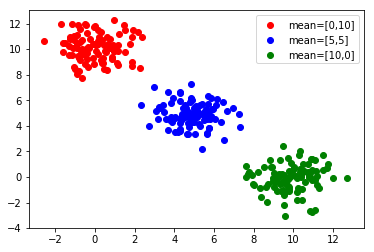

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

M=2 # dimention of input data
K=3 # the number of classes
n=100 # the number of data per each class
N=n*K # total number of data

# sample dataset
np.random.seed(0)
tf.set_random_seed(0)

X1 = np.random.randn(n,M) + np.array([0,10])
X2 = np.random.randn(n,M) + np.array([5,5])
X3 = np.random.randn(n,M) + np.array([10,0])
Y1 = np.array([[1,0,0] for i in range(n)])
Y2 = np.array([[0,1,0] for i in range(n)])
Y3 = np.array([[0,0,1] for i in range(n)])

X = np.concatenate((X1, X2, X3), axis=0)
Y = np.concatenate((Y1, Y2, Y3), axis=0)

print("X.shape = ", X.shape)
print("Y.shape = ", Y.shape)

plt.scatter(X1[:,0], X1[:,1], c='r', label="mean=[0,10]")
plt.scatter(X2[:,0], X2[:,1], c='b', label="mean=[5,5]")
plt.scatter(X3[:,0], X3[:,1], c='g', label="mean=[10,0]")
plt.legend()
plt.show()

In [3]:
from sklearn.utils import shuffle

# model setting
W = tf.Variable(tf.zeros([M,K]))
b = tf.Variable(tf.zeros([K]))

x = tf.placeholder(tf.float32, shape=[None, M])
t = tf.placeholder(tf.float32, shape=[None, K])
y = tf.nn.softmax(tf.matmul(x,W) + b)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(t * tf.log(y), reduction_indices=[1]))

train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(t,1))


# learning
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

batch_size = 50
n_batches = N // batch_size

for epoch in range(20):
    X_, Y_ = shuffle(X,Y)
    
    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
        
        sess.run(train_step, feed_dict={
            x: X_[start:end],
            t: Y_[start:end]
        })
        
# check result
X_, Y_ = shuffle(X,Y)

classified = correct_prediction.eval(session=sess, feed_dict={
    x: X_[0:10],
    t: Y_[0:10]
})
prob = y.eval(session=sess, feed_dict={
    x: X_[0:10]
})

print('classified:')
print(classified)
print()
print('output probability:')
print(prob)
print()
print("parameter:\n W={}, \n b={}".format(sess.run(W), sess.run(b)))

classified:
[ True  True  True  True  True  True  True  True  True  True]

output probability:
[[  9.98682678e-01   1.31731527e-03   2.58784910e-10]
 [  3.43130948e-03   9.69049275e-01   2.75194254e-02]
 [  9.69157398e-01   3.08425445e-02   5.09097688e-08]
 [  1.93514787e-02   9.70684528e-01   9.96400509e-03]
 [  4.12158085e-09   8.59103166e-03   9.91409004e-01]
 [  1.71545204e-02   9.76335824e-01   6.50969939e-03]
 [  2.30860678e-07   4.24577259e-02   9.57542002e-01]
 [  7.25345686e-08   8.87839682e-03   9.91121531e-01]
 [  8.43027297e-12   1.41838231e-04   9.99858141e-01]
 [  9.95894194e-01   4.10580169e-03   2.68717937e-09]]

parameter:
 W=[[-1.09312928  0.30058849  0.79254127]
 [ 0.79545879  0.2939766  -1.08943546]], 
 b=[-0.05914814  0.10808326 -0.04893514]


学習結果を図示すると次の通り。

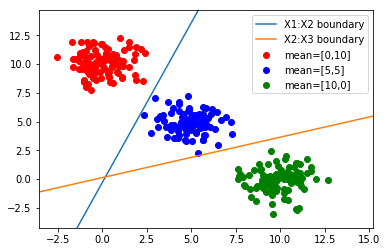

In [4]:
Wv=np.array([[-1.09316552, 0.30220953, 0.79095626], 
             [0.79625851, 0.2952835, -1.09154177]])
bv=np.array([-0.06021591, 0.10705093, -0.04683502])

XL = np.linspace(np.min(X[:,0])*1.4, np.max(X[:,0])*1.4, 1000)
C12 = (1/(Wv[1][1]-Wv[1][0])) * ((Wv[0][0] - Wv[0][1]) * XL + (bv[1] - bv[0]))
C23 = (1/(Wv[1][2]-Wv[1][1])) * ((Wv[0][1] - Wv[0][2]) * XL + (bv[2] - bv[1]))
#C31 = (1/(Wv[1][0]-Wv[1][2])) * ((Wv[0][2] - Wv[0][0]) * XL + (bv[0] - bv[2]))

plt.plot(XL, C12, label="X1:X2 boundary")
plt.plot(XL, C23, label="X2:X3 boundary")
#plt.plot(XL, C31, label="X3:X1 boundary")
plt.scatter(X1[:,0], X1[:,1], c='r', label="mean=[0,10]")
plt.scatter(X2[:,0], X2[:,1], c='b', label="mean=[5,5]")
plt.scatter(X3[:,0], X3[:,1], c='g', label="mean=[10,0]")
plt.xlim(np.min(X[:,0])*1.4, np.max(X[:,0])*1.2)
plt.ylim(np.min(X[:,1])*1.4, np.max(X[:,1])*1.2)
plt.legend()
plt.show()

---
#### kerasによる実装

In [6]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from sklearn.utils import shuffle

model = Sequential()
model.add(Dense(input_dim=M, units=K))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.1))

batch_size = 50
model.fit(X, Y, epochs=20, batch_size = batch_size)

X_, Y_ = shuffle(X,Y)
classes = model.predict_classes(X_[0:10], batch_size=batch_size)
prob = model.predict_proba(X_[0:10], batch_size=batch_size)

print('classified:')
print(np.argmax(model.predict(X_[0:10]), axis=1)== classes)
print()
print('output probability:')
print(prob)

Epoch 1/20
300/300 [==============================] - 0s 125us/step - loss: 1.6481
Epoch 2/20
300/300 [==============================] - 0s 14us/step - loss: 0.2228
Epoch 3/20
300/300 [==============================] - 0s 14us/step - loss: 0.1576
Epoch 4/20
300/300 [==============================] - 0s 14us/step - loss: 0.1223
Epoch 5/20
300/300 [==============================] - 0s 18us/step - loss: 0.1021
Epoch 6/20
300/300 [==============================] - 0s 14us/step - loss: 0.0875
Epoch 7/20
300/300 [==============================] - 0s 15us/step - loss: 0.0763
Epoch 8/20
300/300 [==============================] - 0s 20us/step - loss: 0.0690
Epoch 9/20
300/300 [==============================] - 0s 14us/step - loss: 0.0628
Epoch 10/20
300/300 [==============================] - 0s 17us/step - loss: 0.0572
Epoch 11/20
300/300 [==============================] - 0s 15us/step - loss: 0.0533
Epoch 12/20
300/300 [==============================] - 0s 14us/step - loss: 0.0499
Epoch 13/20


---
次のnotebookへ続く。